# Initialization

We must run some initialization code to import plotting lib and other helper methods 

In [4]:
%matplotlib widget

%load_ext autoreload
%autoreload 1

from pathlib import Path
import re
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qgrid

# make sure we have log dir
while not Path('log').is_dir():
    %cd ..

%aimport vis

pd.plotting.register_matplotlib_converters()
# wait until https://github.com/quantopian/qgrid/issues/261 is merged
# qgrid.enable()

def get_raw(df, jobid):
    return df.loc[[jobid]]['Raw'][0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Auto-PyTorch runs

### Two runs of Auto-PyTorch with 20 budgets and 2 iterations

In [46]:
df = pd.read_csv('log/2019-09-22T20:35:20/jobs.csv')
# df = pd.read_csv('log/2019-09-23T10:57:58/jobs.csv', sep='\t')
df['StartTime'] = pd.to_datetime(df['Start Time'])
df['EndTime'] = pd.to_datetime(df['End Time'])
df['Duration'] = df.EndTime - df.StartTime
df['Worker'] = pd.to_numeric(df.Worker)

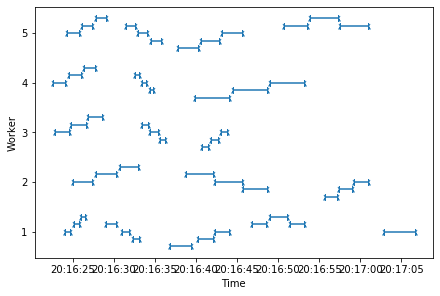

In [49]:
%matplotlib inline
_, ax = vis.subplots('Two runs of Auto-PyTorch with 20 budgets and 2 iterations')
ax = vis.job_timeline(df.Worker, df.StartTime, df.EndTime, ax=ax)

### One run of hyperopt with 300 max eval

In [50]:
total = pd.DataFrame()
for node in range(1, 5):
    df = pd.read_csv(f'log/2019-09-30T10:04:29/hyper{node}.csv', sep='\t',
                     names=['StartTime', 'EndTime', 'Node'])
    total = total.append(df)
total = total.reset_index(drop=True)
total['Node'] = pd.to_numeric(total.Node)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
total = total.reset_index(drop=True)

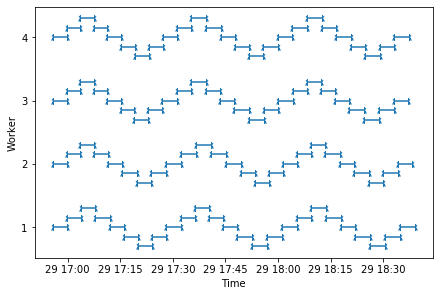

In [51]:
%matplotlib inline
_, ax = vis.subplots('One run of hyperopt with 300 max eval')
ax = vis.job_timeline(total.Node, total.StartTime, total.EndTime, ax=ax)

In [12]:
ax.figure.savefig('/tmp/workspace/2iterautopy.png', dpi=900)

### One run of Auto-PyTorch with 200 budget and 10 iterations.

#### The timeline
It seems that the algorithm can finish earlier than max iterations

In [69]:
total = pd.DataFrame()
for node in range(1, 6):
    df = pd.read_csv(f'log/2019-09-30T10:04:29/node{node}.csv', sep='\t',
                     names=['Iter', 'Unknown', 'JobId', 'StartTime', 'EndTime'])
    df['Node'] = node
    total = total.append(df)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
total = total.reset_index(drop=True)

In [70]:
#%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 200 budget and 10 iterations')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### The job duration distribution of the same run

In [55]:
total['Duration'] = total.EndTime - total.StartTime
total['Duration'] = total.Duration.astype('timedelta64[s]')

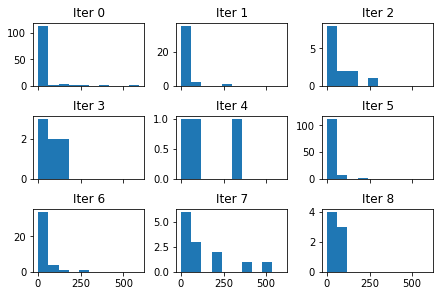

In [56]:
%matplotlib inline
_, axs = vis.subplots('Job duration distribution of the same run', nrows=3, ncols=3, sharex=True)
grouped = total.groupby('Iter')
bins = None
for ax, (it, grp) in zip(axs.flat, total.groupby('Iter')):
    _, bins, _ = ax.hist(grp.Duration, bins=bins)
    ax.set_title(f'Iter {it}')

### 10 workers and two iterations

#### The timeline

In [57]:
total = pd.DataFrame()
for node in range(1, 10):
    df = pd.read_csv(f'log/2019-10-07T11:29:19/worker{node}.log', sep='\t',
                     names=['StartTime', 'EndTime', 'Iter', 'JobId', 'Budget', 'Epoches'])
    df['Node'] = node
    total = total.append(df)
total['StartTime'] = pd.to_datetime(total.StartTime)
total['EndTime'] = pd.to_datetime(total.EndTime)
for col in ['Budget', 'Iter', 'JobId', 'Epoches']:
    total[col] = pd.to_numeric(total[col])
total = total.reset_index(drop=True)

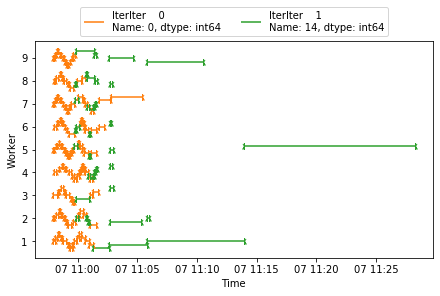

In [58]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 20 budget and 2 iterations with 10 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
vis.legend(ax, ncol=2)

#### \# of jobs and speed distribution

In [59]:
total['Duration'] = total.EndTime - total.StartTime
total['Duration'] = total.Duration.astype('timedelta64[s]')

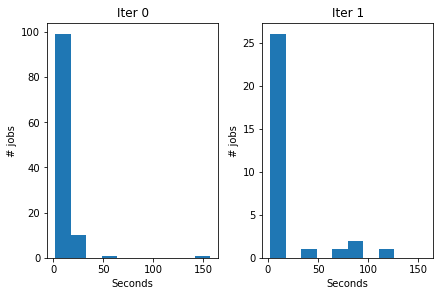

In [60]:
%matplotlib inline
_, axs = vis.subplots('Job duration distribution of the same run', nrows=1, ncols=2, sharex=True)
grouped = total.groupby('Iter')
bins = None
for ax, (it, grp) in zip(axs.flat, total.groupby('Iter')):
    _, bins, _ = ax.hist(grp.Duration, bins=bins)
    ax.set_title(f'Iter {it}')
    ax.set_xlabel('Seconds')
    ax.set_ylabel('# jobs')

Text(0, 0.5, 'Second/Epoch')

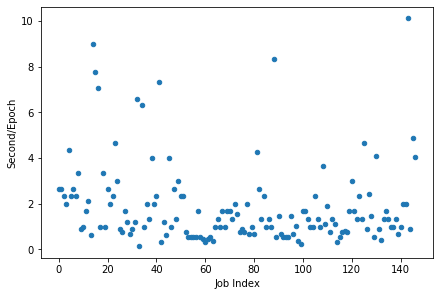

In [61]:
speed = total.Duration / total.Epoches
_, ax = vis.subplots('Job speed')
speed.reset_index().plot(x='index', y=0, ax=ax, kind='scatter')
ax.set_xlabel('Job Index')
ax.set_ylabel('Second/Epoch')

### One run with 20 budget and 5 iterations with 10 workers

In [64]:
total = vis.load_jobs('tentacled-seal', 'num_worker-10')

Using existing log_dir: 20191007-tentacled-seal
Loading log/20191007-tentacled-seal/num_worker-10-jobs.csv


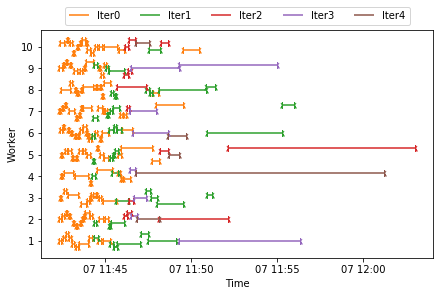

In [66]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 20 budget and 5 iterations with 10 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=5)

### One run with 100 budget and 5 iterations with 7 workers

In [68]:
total = vis.load_jobs('pygmy', '7')

Using existing log_dir: 20191008-pygmy-tapir
Loading log/20191008-pygmy-tapir/num_worker-7-jobs.csv


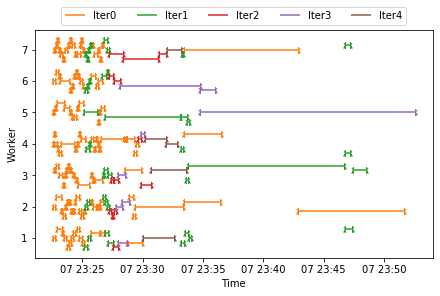

In [70]:
%matplotlib inline
_, ax = vis.subplots('One run of Auto-PyTorch with 100 budget and 5 iterations with 7 workers')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=5)

### 100 budget and diff \# of workers

Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-1-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-2-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-3-iter-15-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-4-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-6-iter-5-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-6-iter-15-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-8-jobs.csv
Using existing log_dir: 20191013-wild-fulmar
Loading log/20191013-wild-fulmar/num_worker-10-jobs.csv


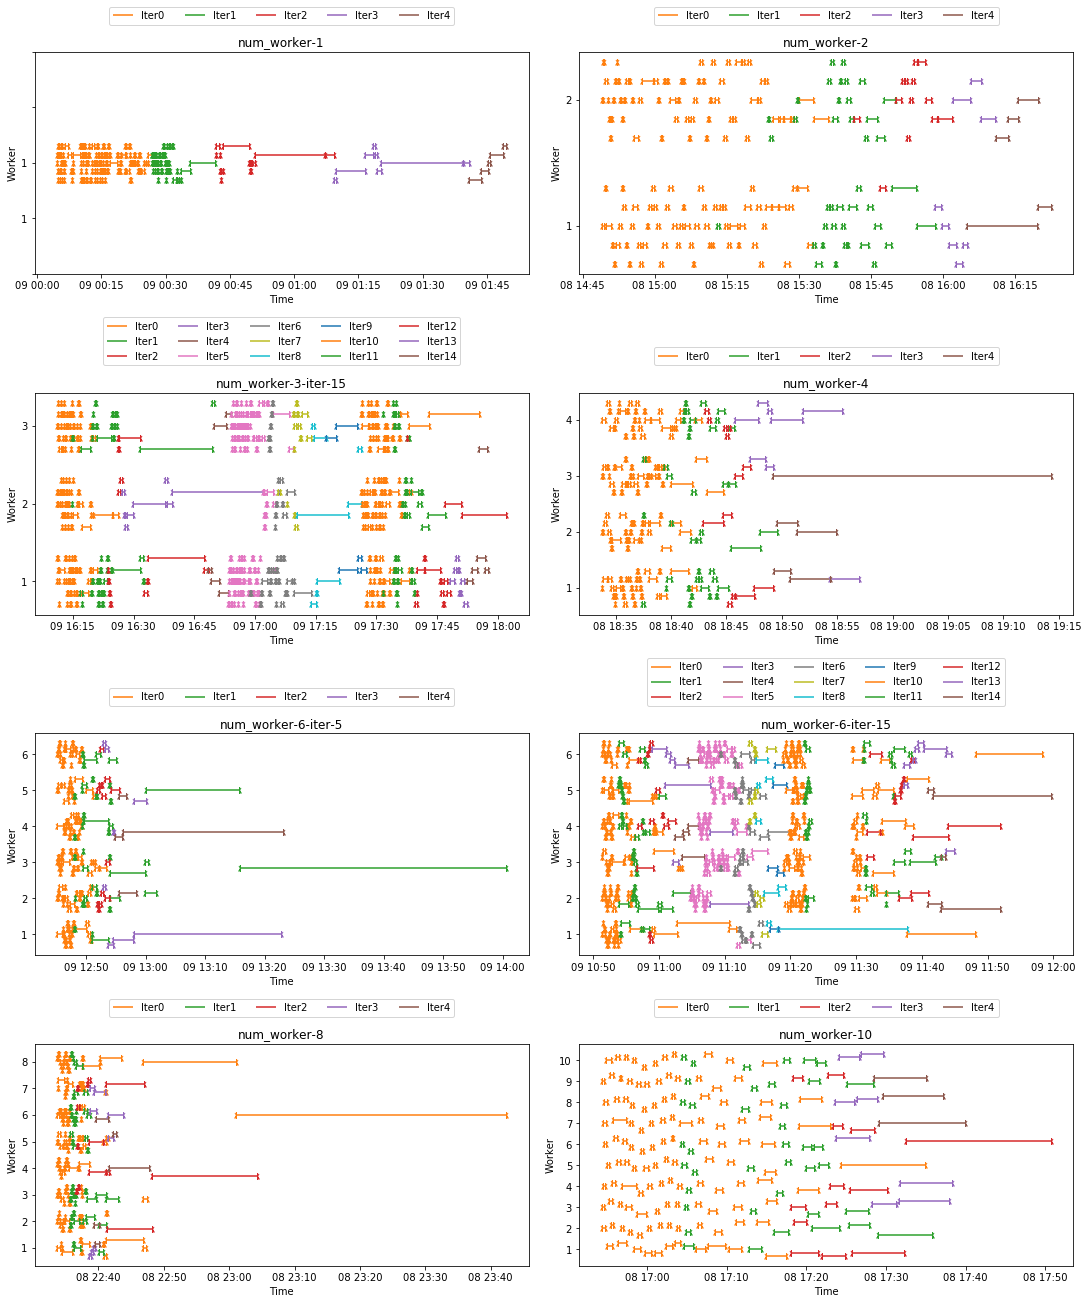

In [76]:
%matplotlib inline
ylims = {
    'num_worker-1': [-2, 2]
}
tags = [
    'num_worker-1',
    'num_worker-2',
    'num_worker-3-iter-15',
    'num_worker-4',
    'num_worker-6-iter-5',
    'num_worker-6-iter-15',
    'num_worker-8',
    'num_worker-10',
]
_, axs = vis.subplots(f'Auto-PyTorch with 100 budget and diff num of workers', ncols=2, nrows=4, figsize=(15, 18))

for tag, ax in zip(tags, axs.flatten()):
    total = vis.load_jobs('wild-fulmar', tag)
    vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
    vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
    ax.set_title(tag)
    ylim = ylims.get(tag, None)
    if ylim:
        ax.set_ylim(ylim)

In [5]:
ylims = {
    'num_worker-1': [-2, 2]
}
tags = [
    'num_worker-1',
    'num_worker-2',
    'num_worker-3',
    'num_worker-4',
    'num_worker-6-iter-5',
    'num_worker-6-iter-15',
    'num_worker-8',
    'num_worker-10',
]
_, axs = vis.subplots(f'Auto-PyTorch with 200 budget and diff num of workers', ncols=2, nrows=4, figsize=(None, 18))

for tag, ax in zip(tags, axs.flatten()):
    total = load_jobs('wild-fulmar', tag)
    vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key}', ax=ax)
    vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
    
    tot_duration = total.EndTime.max() - total.StartTime.min()
    ax.set_title(f'{tag}: JCT: {tot_duration}')
    ylim = ylims.get(tag, None)
    if ylim:
        ax.set_ylim(ylim)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Loading log/wild-fulmar/multiworker-num_worker-1-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-2-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-3-iter-15-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-4-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-6-iter-5-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-6-iter-15-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-8-jobs.csv
Loading log/wild-fulmar/multiworker-num_worker-10-jobs.csv


### Repeat 1 worker and 3 workers exp with 200 budget

Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/num_worker-1-iter-5-name-a-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/num_worker-3-iter-5-name-a-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/num_worker-1-iter-5-name-b-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/num_worker-3-iter-5-name-b-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/num_worker-1-iter-5-name-c-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/num_worker-3-iter-5-name-c-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/time_budget-num_worker-1-iter-5-name-a-jobs.csv
Using existing log_dir: 20191023-imaginary-impala
Loading log/20191023-imaginary-impala/time_budget-num_worker-3-iter-5-

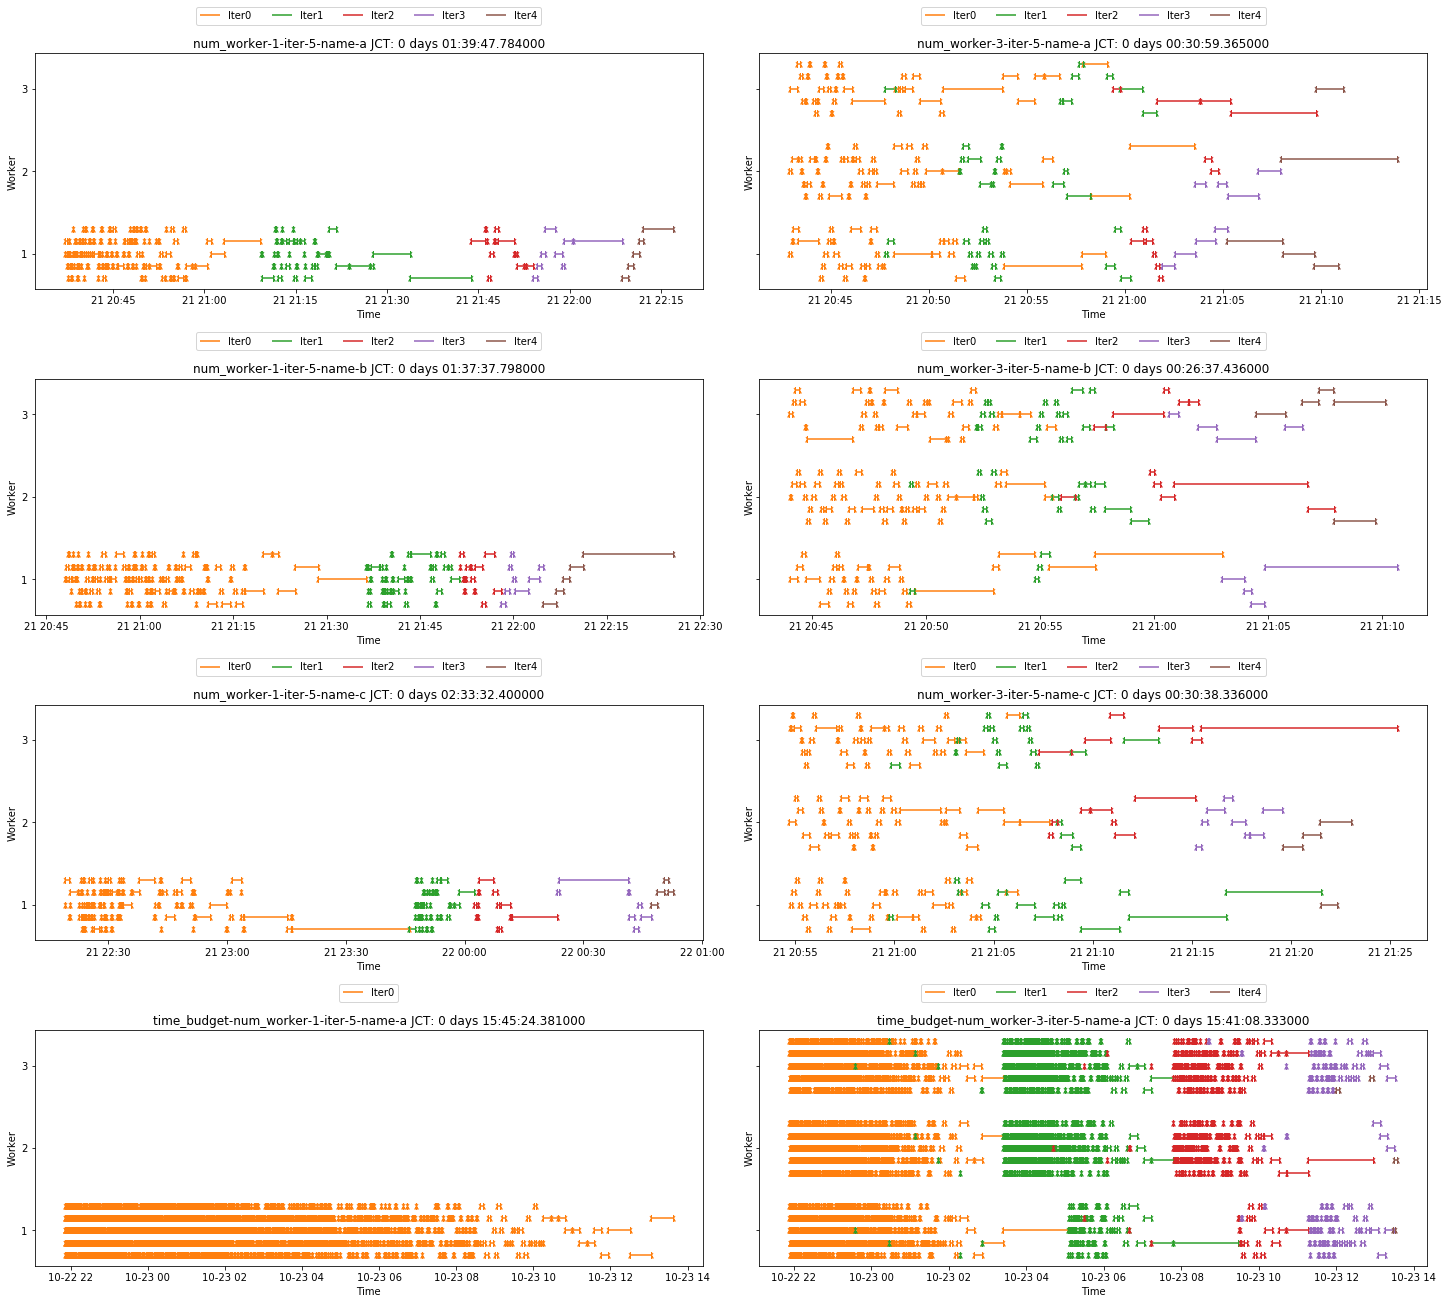

In [80]:
tags = [
    'num_worker-1-iter-5-name-a',
    'num_worker-3-iter-5-name-a',
    'num_worker-1-iter-5-name-b',
    'num_worker-3-iter-5-name-b',
    'num_worker-1-iter-5-name-c',
    'num_worker-3-iter-5-name-c',
    'time_budget-num_worker-1-iter-5-name-a',
    'time_budget-num_worker-3-iter-5-name-a',
]
_, axs = vis.subplots(f'Auto-PyTorch with 200 budget repeat exp', ncols=2, nrows=4, figsize=(20, 18), sharey=True)

for tag, ax in zip(tags, axs.flatten()):
    total = vis.load_jobs('imaginary-impala', tag)
    vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
    vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
    
    tot_duration = total.EndTime.max() - total.StartTime.min()
    ax.set_title(f'{tag} JCT: {tot_duration}')

# Auto-PyTorch with Distributed Training

## 3 workers, 2 workers per job

Using existing log_dir: 20191124-meticulous-impala
Loading log/20191124-meticulous-impala/num_worker-3-iter-2-name-a-jobs.csv
0 days 00:16:52.488000


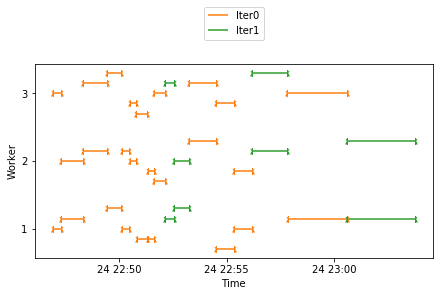

In [86]:
total = vis.load_jobs('met', 'num_worker-3-iter-2-name-a')
_, ax = vis.subplots(f'Auto-PyTorch with 3 workers, 2 workers per job')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

## 3 workers, baseline

Using existing log_dir: 20191124-meticulous-impala
Loading log/20191124-meticulous-impala/num_worker-3-iter-2-name-baseline-jobs.csv
0 days 00:09:15.285000


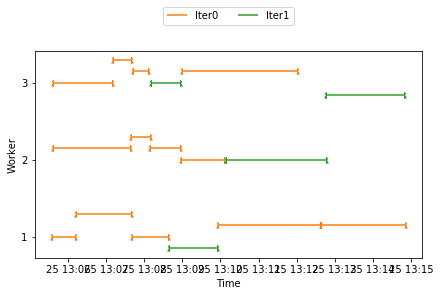

In [88]:
total = vis.load_jobs('met', 'name-baseline')
_, ax = vis.subplots(f'Auto-PyTorch with 3 workers, baseline')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=2, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

## 4 workers, 2 workers per job

Using existing log_dir: 20191125-awesome-fennec
Loading log/20191125-awesome-fennec/num_worker-4-iter-5-name-a-jobs.csv
0 days 00:45:19.523000


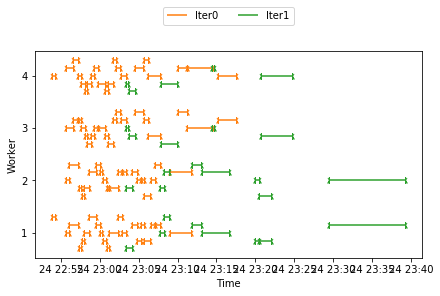

In [91]:
total = vis.load_jobs('awesome', 'num_worker-4-*-name-a')
total = total[total.Iter <= 1]
_, ax = vis.subplots(f'Auto-PyTorch with 4 workers, 2 workers per job')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

## 2 workers, baseline, sync iter

In [3]:
total = vis.load_jobs('maize', 'name-cc')
_, ax = vis.subplots(f'Auto-PyTorch with sync iter')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

Using existing log_dir: 20191126-maize-elephant
Loading log/20191126-maize-elephant/num_worker-2-iter-5-name-cc-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0 days 02:43:14.443000


## 2 workers, sync iter, RungBased sched

Using existing log_dir: 20191202-vivacious-harrier
Loading log/20191202-vivacious-harrier/num_worker-2-iter-1-name-RungBased2-jobs.csv
0 days 00:19:30.147000


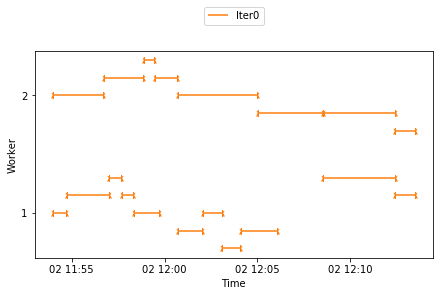

In [93]:
total = vis.load_jobs('viva', 'name-RungBased2')
_, ax = vis.subplots(f'Auto-PyTorch with sync iter')
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=total.Iter, label='Iter{key[0]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

## 3 workers, 3 iters, 50 budget


### Using CoJob scheduling

`funny-tamarin`

Using existing log_dir: 20191204-funny-tamarin
Loading log/20191204-funny-tamarin/num_worker-3-iter-3-name-job5-jobs.csv
0 days 01:09:25.183000


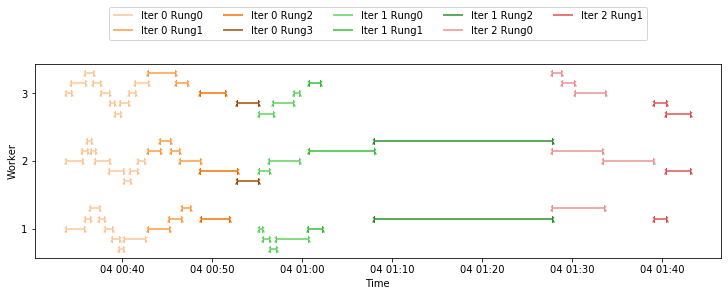

In [96]:
total = vis.load_jobs('funny-tamarin', 'name-job5').sort_values(by=['Iter', 'Rung', 'JobId'])
_, ax = vis.subplots(f'Auto-PyTorch with sync iter', figsize=(10, None))
vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=[total.Iter,total.Rung],
                 label='Iter {key[0]} Rung{key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))
print(total.EndTime.max() - total.StartTime.min())

### Use Bin Scheduling
`20191207-tacky-gazelle`

- Control group
    + `name-bin4` (not correct yet)
    + `name-3-50-bin9`
    + `name-3-200-bin1`
    + `name-bin-20-200-3wk`
- Baseline:
    + `name-3_baseline`
    + `name-bin-20-200-3wk-baseline`

In [4]:
slug = 'tacky-gazelle'
for name in [
    'name-3_baseline',
    'name-3-50-bin9',
    'name-3-200-bin1',
    'name-bin-50-3wk',
    'name-bin-50-5wk',
    'name-bin-50-5wk-baseline',
    'name-bin-20-200-3wk',
    'name-bin-20-200-3wk-cojob',
    'name-bin-20-200-3wk-cojob-2',
    'name-bin-20-200-3wk-cojob-3',
    'name-bin-20-200-3wk-baseline',
    'name-bin-20-200-5wk-cojob',
    'name-bin-20-200-5wk-baseline',
]:
    df = vis.load_jobs(slug, name)

Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-3_baseline-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-3-50-bin9-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-3-200-bin1-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-bin-50-3wk-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-5-iter-3-name-bin-50-5wk-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-5-iter-3-name-bin-50-5wk-baseline-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-bin-20-200-3wk-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter

#### bin-20-200-5wk-cojob vs bin-20-200-5wk-baseline

In [5]:
vis.timelines('tacky-gazelle', ['bin-20-200-5wk-cojob', 'bin-20-200-5wk-baseline'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191207-tacky-gazelle


(<Figure size 640x480 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed7711f320>],
       dtype=object))

#### bin-20-200-3wk-cojob2 vs bin-20-200-3wk-baseline

In [6]:
vis.timelines('tacky-gazelle', [
    'bin-20-200-3wk-cojob-2',
    'bin-20-200-3wk-cojob-3',
    'bin-20-200-3wk-baseline',
], figsize=(None, 12))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191207-tacky-gazelle


(<Figure size 640x480 with 3 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed7700c400>],
       dtype=object))

#### 3-50-bin9 vs 3-baseline

In [7]:
_, axs = vis.subplots(f'Auto-PyTorch with sync iter, tacky-gazelle', sharex=True, nrows=2)

ax = axs[0]
df = vis.d.tacky_gazelle._3_baseline
vis.job_timeline(df.Node,
                 df.StartTime, df.EndTime,
                 groupby=[df.Iter, df.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.18))
ax.set_title('3_baseline')

ax = axs[1]
df = vis.d.tacky_gazelle._3_50_bin9
diff = df.StartTime.min() - vis.d.tacky_gazelle._3_baseline.StartTime.min()
        
vis.job_timeline(df.Node,
                 df.StartTime - diff, df.EndTime - diff,
                 groupby=[df.Iter, df.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.18))
ax.set_title('3-50-bin9')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, '3-50-bin9')

#### bin-50-5wk vs bin-50-5wk-baseline

In [114]:
_, axs = vis.subplots(f'Auto-PyTorch with sync iter, tacky-gazelle, bin-50-5wk', sharex=True, nrows=2)

ax = axs[0]
df = d.tacky_gazelle.bin_50_5wk
vis.job_timeline(df.Node,
                 df.StartTime, df.EndTime,
                 groupby=[df.Iter, df.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.18))
ax.set_title('bin-50-5wk')

ax = axs[1]
df = d.tacky_gazelle.bin_50_5wk_baseline
diff = df.StartTime.min() - d.tacky_gazelle.bin_50_5wk.StartTime.min()
        
vis.job_timeline(df.Node,
                 df.StartTime - diff, df.EndTime - diff,
                 groupby=[df.Iter, df.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.18))
ax.set_title('bin-50-5wk-baseline')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'bin-50-5wk-baseline')

## 20-400 budgets

### bin-20-400-4wk vs baseline

`bin-20-400-5wk-baseline` is actually 4wk.

In [8]:
slug = 'tacky-gazelle'
for name in [
    'bin-20-400-5wk-baseline',
    'bin-20-400-4wk-cojob',
]:
    vis.load_jobs(slug, name)

Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-4-iter-3-name-bin-20-400-5wk-baseline-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-4-iter-3-name-bin-20-400-4wk-cojob-jobs.csv


In [9]:
vis.timelines(slug, ['bin-20-400-5wk-baseline', 'bin-20-400-4wk-cojob'], title='4wk')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191207-tacky-gazelle


(<Figure size 640x480 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed76e464a8>],
       dtype=object))

### bin-20-400-3wk vs baseline

In [48]:
slug = 'tacky-gazelle'
for name in [
    'bin-20-400-3wk-cojob',
    'bin-20-400-3wk-baseline',
]:
    vis.load_jobs(slug, name)

Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-bin-20-400-3wk-cojob-jobs.csv
Using existing log_dir: 20191207-tacky-gazelle
Loading log/20191207-tacky-gazelle/num_worker-3-iter-3-name-bin-20-400-3wk-baseline-jobs.csv


In [50]:
vis.timelines(slug, ['bin-20-400-3wk-cojob', 'bin-20-400-3wk-baseline'], title='3wk')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191207-tacky-gazelle


## Reproducability Test

`20191206-optimistic-macaw`

Using baseline scheduling for multiple runs, budget 50

In [10]:
total = vis.load_jobs('optimistic-macaw', 'name-BaselineD1')
total = vis.load_jobs('optimistic-macaw', 'name-BaselineD2')

Using existing log_dir: 20191206-optimistic-macaw
Loading log/20191206-optimistic-macaw/num_worker-3-iter-3-name-BaselineD1-jobs.csv
Using existing log_dir: 20191206-optimistic-macaw
Loading log/20191206-optimistic-macaw/num_worker-3-iter-3-name-BaselineD2-jobs.csv


In [11]:
_, axs = vis.subplots(f'Auto-PyTorch with sync iter, two runs', sharex=True, nrows=2)

ax = axs[0]
total = vis.d.optimistic_macaw.BaselineD1
# record normalize time
refpoint = total.StartTime.min()

vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=[total.Iter,total.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))

ax = axs[1]
total = vis.d.optimistic_macaw.BaselineD2
# normalize time
diff = total.StartTime.min() - vis.d.optimistic_macaw.BaselineD1.StartTime.min()

vis.job_timeline(total.Node, total.StartTime - diff, total.EndTime - diff, groupby=[total.Iter,total.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## DelaySchedule

### 3 workers, 3 iters, 50 budget, sync iter
`20191208-tiny-tanuki`

uses the same settings as `optimistic-macaw`, so using them as baseline

`DelaySchedD1` looks like doesn't have much improvements because of the estimator doesn't set a high enough worker number
`DelaySchedD2` shows that
    1. single job is somehow slower
    2. (1, 2, 0) is not scaled up
   
we will enlarge the budget to see what's going on in next section 

In [12]:
slug = 'tiny-tanuki'
for name in ['name-DelaySchedD1', 'name-DelaySchedD2']:
    df = vis.load_jobs_v2(slug, name)

Using existing log_dir: 20191208-tiny-tanuki
Loading log/20191208-tiny-tanuki/multiworker-num_worker-3-iter-3-output-1-name-DelaySchedD1.jsonl
Using existing log_dir: 20191208-tiny-tanuki
Loading log/20191208-tiny-tanuki/multiworker-num_worker-3-iter-3-output-1-name-DelaySchedD2.jsonl


In [13]:
_, axs = vis.subplots(f'Auto-PyTorch with delaysched', sharex=True, nrows=2)

ax = axs[0]
total = vis.d.optimistic_macaw.BaselineD1

vis.job_timeline(total.Node, total.StartTime, total.EndTime, groupby=[total.Iter,total.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))

ax = axs[1]
total = vis.d.tiny_tanuki.DelaySchedD2
# normalize time
diff = total.StartTime.min() - vis.d.optimistic_macaw.BaselineD1.StartTime.min()

vis.job_timeline(total.Node, total.StartTime - diff, total.EndTime - diff, groupby=[total.Iter,total.Rung],
                 label='Iter {key[0]} Rung {key[1]}', ax=ax)
vis.legend(ax, ncol=5, bbox_to_anchor=(0.5, 1.1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [130]:
df[(df.Iter == 1) & (df.Rung == 2)]

,Iter,Rung,JobId,SubmitTime,StartTime,EndTime,Budget,Epoches,NumWorker,SkippedCount,OptNum,EstRun,Node,Duration
53,1,2,0,2019-12-08 22:15:45.419407129,2019-12-08 22:15:45.528936863,2019-12-08 22:26:18.209393263,50.0,51,1,0,1,0,3,632.0


### 3 workers, 3 iters, 20-200 budget, sync iter

`20191208-benign-hyrax`

We first discovered that batch size wasn't added as a scalable key.

- `DelaySched-20-200` shows that job results were not registered in model. Job (0, 2, 0)'s model is empty, but at least (0, 1, 1) should be in the model.
- `DelaySched-20-200D2` shows that there were exceptions when add_sample.
- `DelaySched-20-200D3` works, but it is too slow even with the same config.
- `DelaySched-20-200D4` run D3 again. It is still slow, but similar to D3.

Let's rerun both baseline and delaysched on exactly the same nodes with iter timing in the next section to see if we can gain any insights.

In [14]:
slug = 'benign-hyrax'
for name in [
    'name-Baseline-20-200',
    'name-DelaySched-20-200',
    'name-DelaySched-20-200D2',
    'name-DelaySched-20-200D3',
    'name-DelaySched-20-200D4',
]:
    df = vis.load_jobs_v2(slug, name)

Using existing log_dir: 20191208-benign-hyrax
Loading log/20191208-benign-hyrax/multiworker-num_worker-3-iter-3-output-1-name-Baseline-20-200.jsonl
Using existing log_dir: 20191208-benign-hyrax
Loading log/20191208-benign-hyrax/multiworker-num_worker-3-iter-3-output-1-name-DelaySched-20-200.jsonl
Using existing log_dir: 20191208-benign-hyrax
Loading log/20191208-benign-hyrax/multiworker-num_worker-3-iter-3-output-1-name-DelaySched-20-200D2.jsonl
Using existing log_dir: 20191208-benign-hyrax
Loading log/20191208-benign-hyrax/multiworker-num_worker-3-iter-3-output-1-name-DelaySched-20-200D3.jsonl
Using existing log_dir: 20191208-benign-hyrax
Loading log/20191208-benign-hyrax/multiworker-num_worker-3-iter-3-output-1-name-DelaySched-20-200D4.jsonl


In [15]:
vis.timelines('benign-hyrax', ['DelaySched-20-200D4', 'DelaySched-20-200D3', 'Baseline-20-200'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191208-benign-hyrax


(<Figure size 640x480 with 3 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed7016feb8>],
       dtype=object))

In [16]:
dfb = vis.d.benign_hyrax.Baseline_20_200
df = vis.d.benign_hyrax.DelaySched_20_200D3

df = df.set_index(['Iter', 'Rung', 'JobId'])
dfb = dfb.set_index(['Iter', 'Rung', 'JobId'])

In [17]:
def get_raw(df, jobid):
    return df.loc[[jobid], 'Raw'].iloc[0]

# there are diffs, but those are only due to JobId assignments different due to job finishing order. They are actually the same.
for i in df.index:
    base = get_raw(dfb, i)['kwargs']['config']
    our = get_raw(df, i)['kwargs']['config']
    
    if our != base:
        print(f'Diff at {i}:')
        print(f'    Base {base}')
        print(f'    Our {our}')
    

Diff at (0, 1, 0):
    Base {'CreateDataLoader:batch_size': 104, 'Imputation:strategy': 'mean', 'InitializationSelector:initialization_method': 'default', 'InitializationSelector:initializer:initialize_bias': 'Yes', 'LearningrateSchedulerSelector:lr_scheduler': 'cosine_annealing', 'LossModuleSelector:loss_module': 'cross_entropy', 'NetworkSelector:network': 'shapedresnet', 'NormalizationStrategySelector:normalization_strategy': 'standardize', 'OptimizerSelector:optimizer': 'adam', 'PreprocessorSelector:preprocessor': 'power_transformer', 'ResamplingStrategySelector:over_sampling_method': 'smote', 'ResamplingStrategySelector:target_size_strategy': 'none', 'ResamplingStrategySelector:under_sampling_method': 'none', 'TrainNode:batch_loss_computation_technique': 'mixup', 'LearningrateSchedulerSelector:cosine_annealing:T_max': 5, 'LearningrateSchedulerSelector:cosine_annealing:T_mult': 1.2347974847499081, 'NetworkSelector:shapedresnet:activation': 'relu', 'NetworkSelector:shapedresnet:block

### 3 workers, 3 iters, 20-200 budget, sync iter. Rerun Baseline and DelaySched

`20191212-classy-caracal`

Continuing from the previous section, we see abnormally different performance of single jobs between baseline and delaysched. We in this section will rerun all of them of the same set of machines with per iter timing on.

Looking at (0, 2, 0). The job takes exactly the duration regardless running using 1/3 workers. Each epoch only runs 0.3 seconds. So I think the reason it's not working is because the dataset is too small. However, trying MNIST using 20-200 budgets never finishes. Maybe setting a smaller budget with larger dataset works.

In [18]:
slug = 'classy-caracal'
for name in [
    'name-Baseline',
    'name-DelaySched',
]:
    vis.load_jobs_v2(slug, name)

Using existing log_dir: 20191212-classy-caracal
Loading log/20191212-classy-caracal/multiworker-num_worker-3-iter-3-output-1-name-Baseline.jsonl
Using existing log_dir: 20191212-classy-caracal
Loading log/20191212-classy-caracal/multiworker-num_worker-3-iter-3-output-1-name-DelaySched.jsonl


In [19]:
vis.timelines(slug, ['Baseline', 'DelaySched'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191212-classy-caracal


(<Figure size 640x480 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed6ae48a90>],
       dtype=object))

In [56]:
df = vis.d.classy_caracal.DelaySched.set_index(['Iter', 'Rung', 'JobId'])
dfb = vis.d.classy_caracal.Baseline.set_index(['Iter', 'Rung', 'JobId'])

In [65]:
df.loc[[(0, 2, 0)]].iloc[0]['Raw']['result']

{'loss': 0.16613247863247863,
 'info': {'loss': 0.8835353222158221,
  'train_accuracy': 0.49430199430199434,
  'lr_scheduler_converged': 1.0,
  'lr': 1.00961883233333e-05,
  'val_accuracy': 0.8338675213675213},
 'epoch': 201,
 'epoch_time': 0.5661336018192563}

In [66]:
dfb.loc[[(0, 2, 0)]].iloc[0]['Raw']['result']

{'loss': 0.17200854700854698,
 'info': {'loss': 0.8089732941391187,
  'train_accuracy': 0.46789784289784286,
  'lr_scheduler_converged': 1.0,
  'lr': 1.00961883233333e-05,
  'val_accuracy': 0.827991452991453},
 'epoch': 201,
 'epoch_time': 0.6626372513311057}

### 3 workers, 3 iters, 1-10 budget, sync iter, MNIST data

Both baseline and delaysched

`20191213-nocturnal-okapi`

In [20]:
slug = 'nocturnal-okapi'
for name in [
    'name-Baseline',
    'name-DelaySched',
    'name-BaselineD2',
    'name-DelaySchedD2',
]:
    vis.load_jobs_v2(slug, name)

Using existing log_dir: 20191213-nocturnal-okapi
Loading log/20191213-nocturnal-okapi/multiworker-num_worker-3-iter-3-output-1-name-Baseline.jsonl
Using existing log_dir: 20191213-nocturnal-okapi
Loading log/20191213-nocturnal-okapi/multiworker-num_worker-3-iter-3-output-1-name-DelaySched.jsonl
Using existing log_dir: 20191213-nocturnal-okapi
Loading log/20191213-nocturnal-okapi/multiworker-num_worker-3-iter-3-output-1-name-BaselineD2.jsonl
Using existing log_dir: 20191213-nocturnal-okapi
Loading log/20191213-nocturnal-okapi/multiworker-num_worker-3-iter-3-output-1-name-DelaySchedD2.jsonl


In [21]:
vis.timelines(slug, ['Baseline', 'DelaySched', 'BaselineD2', 'DelaySchedD2'], figsize=(None, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191213-nocturnal-okapi


(<Figure size 640x480 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed6ac3ea58>],
       dtype=object))

In [77]:
df = vis.d.nocturnal_okapi.DelaySched.set_index(['Iter', 'Rung', 'JobId'])
dfb = vis.d.nocturnal_okapi.Baseline.set_index(['Iter', 'Rung', 'JobId'])

# Exp for ICML

List of exps

- `20200201-wooden-skunk`
    * `MNIST` : Default Baseline **sync** scheduling. **MNIST** dataset. 10 iter. 1-50 budget
    * `Async22DS` : Default Baseline **async** scheduling. **OpenML22** dataset. 3 iter. 1-50 budget
    * `CoJob22DS` : CoJobBased **sync** scheduling. **OpenML22** dataset. 3 iter. 1-50 budget
    * `ASyncCoJobMNIST` : CoJobBased **async** scheduling. **MNIST** dataset. 3 iter. 1-50 budget
    * `CoJobBasedMNIST`: CoJobBased **sync** scheduling. **MNIST** dataset. 3 iter. 1-50 budget
    * `CoJobBasedMNISTD2`: CoJobBased **sync** scheduling. **MNIST** dataset. 3 iter. 1-50 budget

## Timeline

In [11]:
names = ['CoJobBasedMNIST', 'AsyncMNIST', 'SyncMNIST']
for name in names:
    vis.load_jobs_v2('wooden-skunk', name)

vis.timelines('wooden-skunk', names, relative=True)

Using existing log_dir: 20200201-wooden-skunk
Loading log/20200201-wooden-skunk/multiworker-num_worker-3-iter-3-output-1-name-CoJobBasedMNIST.jsonl
Using existing log_dir: 20200201-wooden-skunk
Loading log/20200201-wooden-skunk/multiworker-num_worker-3-iter-3-output-1-name-AsyncMNIST.jsonl
Using existing log_dir: 20200201-wooden-skunk
Loading log/20200201-wooden-skunk/multiworker-num_worker-3-iter-3-output-1-name-SyncMNIST.jsonl


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20200201-wooden-skunk


(<Figure size 640x480 with 3 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe60bf2f828>],
       dtype=object))

In [16]:
vis.d.wooden_skunk.CoJobBasedMNIST.NumWorker.unique()

array([1, 3, 2])

## Accuracy vs time

In [6]:
for name in [
    'AsyncMNIST',
    'MNIST'
]:
    vis.load_jobs_v2('wooden-skunk', name)

vis.losses('wooden-skunk', ['AsyncMNIST', 'MNIST'])

Using existing log_dir: 20200201-wooden-skunk
Loading log/20200201-wooden-skunk/multiworker-num_worker-3-iter-3-output-1-name-AsyncMNIST.jsonl
Using existing log_dir: 20200201-wooden-skunk
Loading log/20200201-wooden-skunk/multiworker-num_worker-3-iter-10-output-1-name-MNIST.jsonl


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20200201-wooden-skunk


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f37b4113fd0>)

## Scale Out 

`20200205-cyan-dinosaur`, multiple direct worker runs

In [54]:
wks = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 32, 64]

log_dir = vis.fuzzy_slug('cyan-dinosaur')
pth = re.compile('epoch time:.*avg: (?P<epoch_time>.+)$')
data = []
for wk in wks:
    for path in log_dir.glob(f'*wk-{wk}-*.log'):
        with path.open() as f:
            for line in f:
                m = pth.search(line.strip())
                if not m:
                    continue
                data.append({
                    'NumWorker': wk,
                    'EpochTime': float(m.group('epoch_time')),
                })
        break
df = pd.DataFrame(data).set_index('NumWorker').sort_index()
df['Tput'] =  df.loc[1, 'EpochTime'] / df.EpochTime

Using existing log_dir: 20200205-cyan-dinosaur


In [57]:
ax = df.plot(y='Tput', marker='+')
ax.set_xlim([1, 65])
ax.set_ylim([0, 65])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0, 65)

## Generate PDF for paper

In [90]:
with plt.style.context(['seaborn-paper', 'mypaper']):
    fig, axs = vis.timelines('tacky-gazelle', [
        'bin-20-200-3wk-cojob-3',
         ], figsize=(6.5, 1.35), constrained_layout=False)
    # df = vis.d.optimistic_macaw.BaselineD1
    # df = total
    # vis.job_timeline(df.Node, df.StartTime, df.EndTime, groupby=[df.Iter], label='Iter{key[0]}', ax=ax)
    # vis.legend(ax, ncol=10, bbox_to_anchor=(0.5, 1.1))
    # remove x labels
    for ax in axs.flatten():
        ax.xaxis.set_visible(False)
    ax.legend().set_visible(False)
    fig.set_size_inches(3.25, 1.35, forward=True)
    #plt.subplots_adjust(left=0.0, right=1, top=1.2, bottom=-0.5)
    plt.tight_layout(pad=-0.5)
    fig.savefig('/tmp/workspace/sync-sched-bin-v2.pdf', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Using existing log_dir: 20191207-tacky-gazelle


In [30]:
# sync-iter-baseline
df = vis.load_jobs('optimistic-macaw', 'BaselineD1')
with plt.style.context(['seaborn-paper', 'mypaper']):
    fig, ax = vis.subplots('sync-iter-baseline')
    df = vis.d.optimistic_macaw.BaselineD1
    
    ref = df.StartTime.min()
    start = (df.StartTime - ref).astype('timedelta64[s]')
    end = (df.EndTime - ref).astype('timedelta64[s]')
    
    vis.job_timeline(df.Node, start, end, groupby=[df.Iter], label='Iter{key[0]}', ax=ax)
    
    ax.set_xlabel('Time (s)')
    ax.legend().set_visible(False)
    fig.set_size_inches(3.25, 1.35, forward=True)
    #plt.subplots_adjust(left=0.0, right=1, top=1.2, bottom=-0.5)
    plt.tight_layout(pad=-0.5)
    fig.savefig('/tmp/workspace/sync-iter-baseline.pdf', dpi=300)

Using existing log_dir: 20191206-optimistic-macaw
Loading log/20191206-optimistic-macaw/num_worker-3-iter-3-name-BaselineD1-jobs.csv


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/peifeng/.conda/envs/autopytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


In [28]:
# async-iter-baseline
df = vis.load_jobs_v2('careful-jaguarundi', 'Async22DS')
with plt.style.context(['seaborn-paper', 'mypaper']):
    fig, ax = vis.subplots('abc')
    df = vis.d.careful_jaguarundi.Async22DS
    
    ref = df.StartTime.min()
    start = (df.StartTime - ref).astype('timedelta64[s]')
    end = (df.EndTime - ref).astype('timedelta64[s]')
    
    vis.job_timeline(df.Node - 3, start, end, groupby=[df.Iter], label='Iter{key[0]}', ax=ax)
    
    ax.set_xlabel('Time (s)')
    ax.legend().set_visible(False)
    fig.set_size_inches(3.25, 1.35, forward=True)
    #plt.subplots_adjust(left=0.0, right=1, top=1.2, bottom=-0.5)
    plt.tight_layout(pad=-0.5)
    fig.savefig('/tmp/workspace/async-iter-baseline.pdf', dpi=300)

Using existing log_dir: 20200201-careful-jaguarundi
Loading log/20200201-careful-jaguarundi/multiworker-num_worker-3-iter-3-output-1-name-Async22DS.jsonl


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/peifeng/.conda/envs/autopytorch/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  app.launch_new_instance()


In [36]:
# sync-iter-cojob
df = vis.load_jobs_v2('skinny-cassowary', 'CoJob22DS')
with plt.style.context(['seaborn-paper', 'mypaper']):
    fig, ax = vis.subplots('sync-iter-cojob')
    df = vis.d.skinny_cassowary.CoJob22DS
    
    ref = df.StartTime.min()
    start = (df.StartTime - ref).astype('timedelta64[s]')
    end = (df.EndTime - ref).astype('timedelta64[s]')
    
    vis.job_timeline(df.Node - 3, start, end, groupby=[df.Iter], label='Iter{key[0]}', ax=ax)
    
    ax.set_xlabel('Time (s)')
    ax.legend().set_visible(False)
    fig.set_size_inches(3.25, 1.35, forward=True)
    #plt.subplots_adjust(left=0.0, right=1, top=1.2, bottom=-0.5)
    plt.tight_layout(pad=-0.5)
    fig.savefig('/tmp/workspace/sync-iter-cojob.pdf', dpi=300)

Using existing log_dir: 20200201-skinny-cassowary
Loading log/20200201-skinny-cassowary/multiworker-num_worker-3-iter-3-output-1-name-CoJob22DS.jsonl


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/peifeng/.conda/envs/autopytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
